# Toxicity Prediction Project
Final Project - Applied Case Studies of Machine Learning and Deep Learning in Key Areas 2

Bulloni Dyuman, Ippolito Manuel, Loddo Fabio - D3A

Import the required Python libraries

In [99]:
# Data handling
import pandas as pd
import numpy as np
import random

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# File handling
import os
from pathlib import Path
import datetime

# RDKit modules
import rdkit as rd
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem

# Modeling
import sklearn 
from sklearn.model_selection import train_test_split

import torch
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # use GPU if available

Settings

In [100]:
# Set seed value
seed_value = 124 #122 123 124, as used in MoleculeNet

# Set torch settings
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)
torch.backends.cudnn.enabled=False
torch.backends.cudnn.deterministic=True

Constants

In [101]:
# Number of bits for morgan fingerprints
MORGAN_BITS = 4096

# Number of radius for morgan fingerprints
MORGAN_RADIUS = 2

## Data Exploration

Import the data

In [102]:
# Define path to the Data folder
DATA_PATH: Path = Path(os.getcwd() + "/Data")
DATA_PATH

WindowsPath('c:/Users/manue/SUPSI/Sixth Semester User/Bio Grasso/Final project/toxicity_prediction/Data')

In [103]:
# Import the clintox dataset
# Clintox dataset contains clinical toxicology data
clintox = pd.read_csv(DATA_PATH / "clintox.csv")
clintox_task = ['CT_TOX']
clintox.head()

,smiles,FDA_APPROVED,CT_TOX
0,*C(=O)[C@H](CCCCNC(=O)OCCOC)NC(=O)OCCOC,1,0
1,[C@@H]1([C@@H]([C@@H]([C@H]([C@@H]([C@@H]1Cl)C...,1,0
2,[C@H]([C@@H]([C@@H](C(=O)[O-])O)O)([C@H](C(=O)...,1,0
3,[H]/[NH+]=C(/C1=CC(=O)/C(=C\C=c2ccc(=C([NH3+])...,1,0
4,[H]/[NH+]=C(\N)/c1ccc(cc1)OCCCCCOc2ccc(cc2)/C(...,1,0


In [104]:
# Import the tox21 dataset
# Tox21 dataset contains in vitro toxicology data 
tox21 = pd.read_csv(DATA_PATH / "tox21.csv")
tox21_tasks = ['NR-AR', 'NR-Aromatase', 'NR-PPAR-gamma', 'SR-HSE', 
               'NR-AR-LBD', 'NR-ER', 'SR-ARE', 'SR-MMP',
               'NR-AhR', 'NR-ER-LBD', 'SR-ATAD5', 'SR-p53']
tox21.head()

,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,mol_id,smiles
0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX3021,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3020,CCN1C(=O)NC(c2ccccc2)C1=O
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,TOX3024,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3027,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C
4,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,TOX3028,CC(O)(P(=O)(O)O)P(=O)(O)O


In vivo data (that in the reference papers come from the dataset RTECS by Biovia) are not available  publicly and require a fee or a subscription to be provided, so we will work on clinical and in vitro data for this project.

### Plot data

#### Clintox dataset

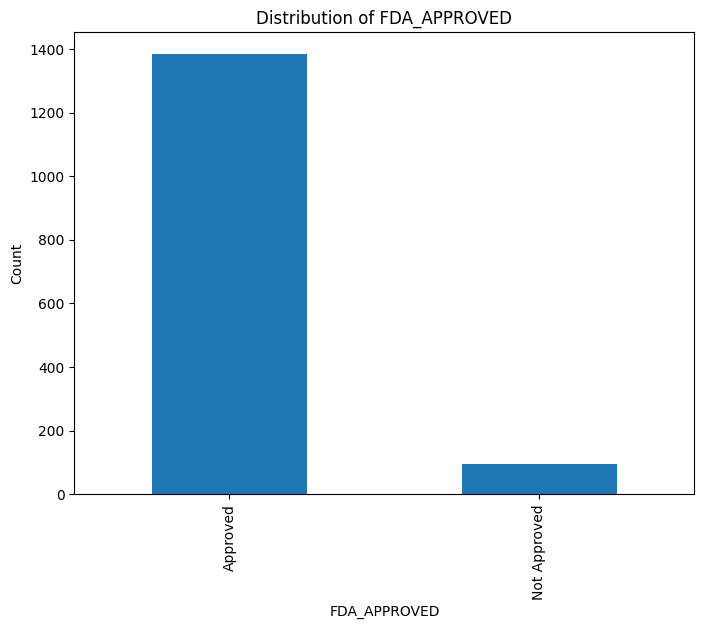

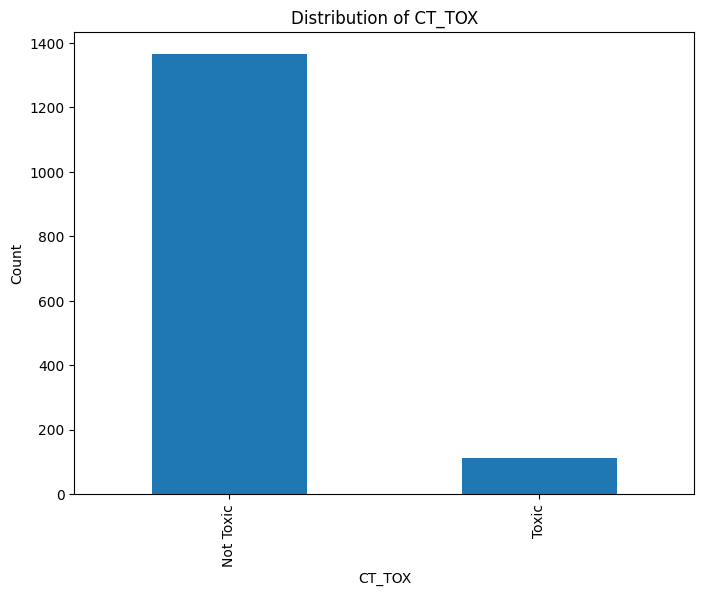

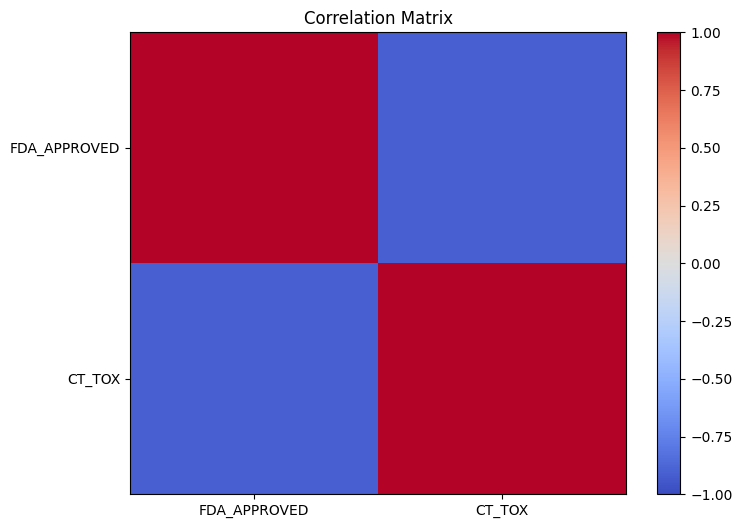

In [121]:
# Plot the distribution of FDA_APPROVED
plt.figure(figsize=(8, 6))
clintox['FDA_APPROVED'].value_counts().plot(kind='bar')
plt.title('Distribution of FDA_APPROVED')
plt.xlabel('FDA_APPROVED')
plt.ylabel('Count')
plt.xticks([0, 1], ['Approved', 'Not Approved'])
plt.show()

# Plot the distribution of CT_TOX
plt.figure(figsize=(8, 6))
clintox['CT_TOX'].value_counts().plot(kind='bar')
plt.title('Distribution of CT_TOX')
plt.xlabel('CT_TOX')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Toxic', 'Toxic'])
plt.show()

# Plot the correlation matrix
plt.figure(figsize=(8, 6))
correlation_matrix = clintox[['FDA_APPROVED', 'CT_TOX']].corr()
plt.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
plt.colorbar()
plt.xticks([0, 1], ['FDA_APPROVED', 'CT_TOX'])
plt.yticks([0, 1], ['FDA_APPROVED', 'CT_TOX'])
plt.title('Correlation Matrix')
plt.show()

From the distributions of CT_TOX we can see that the dataset is unbalanced, as there are way more non toxic drugs than toxic drugs in it. The same for FDA_APPROVED, we have way more FDA approved drugs than non-FDA-approved drugs in the dataset.

It seems there is a net inverse correlation between FDA_APPROVED and CT_TOX. IT makes sense that FDA approved drugs are not toxic.

#### Tox21 dataset

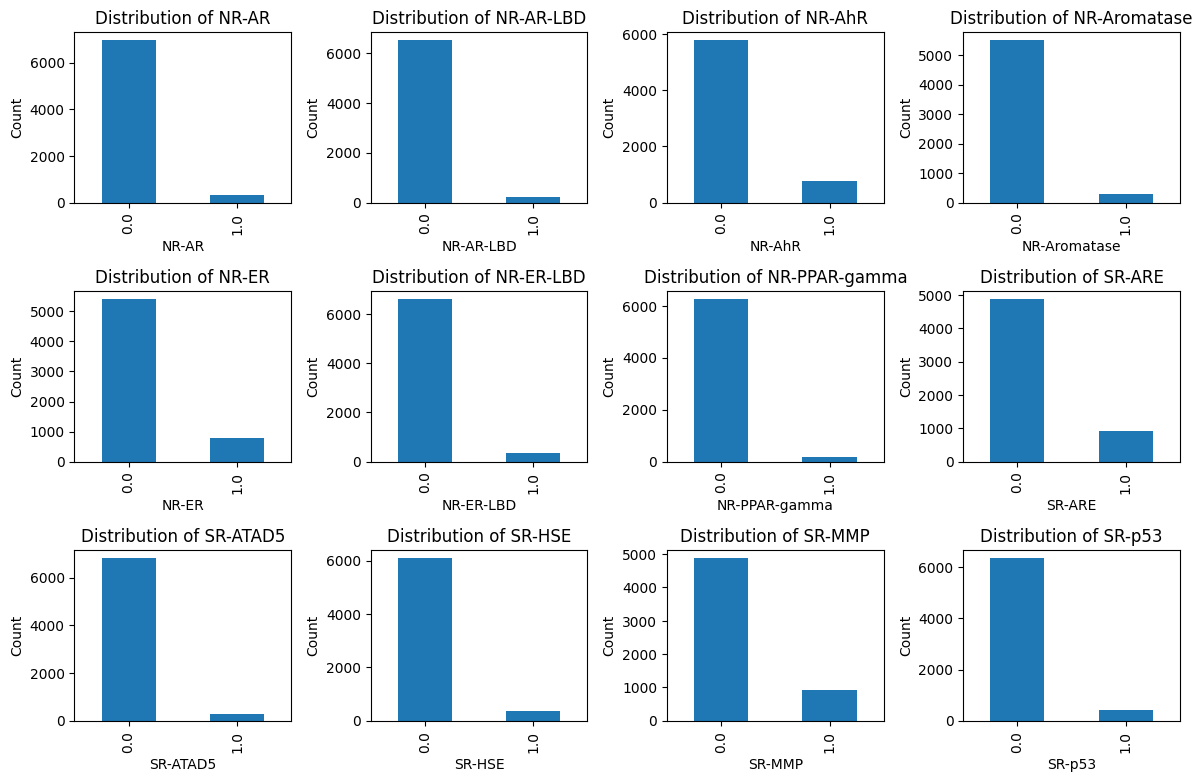

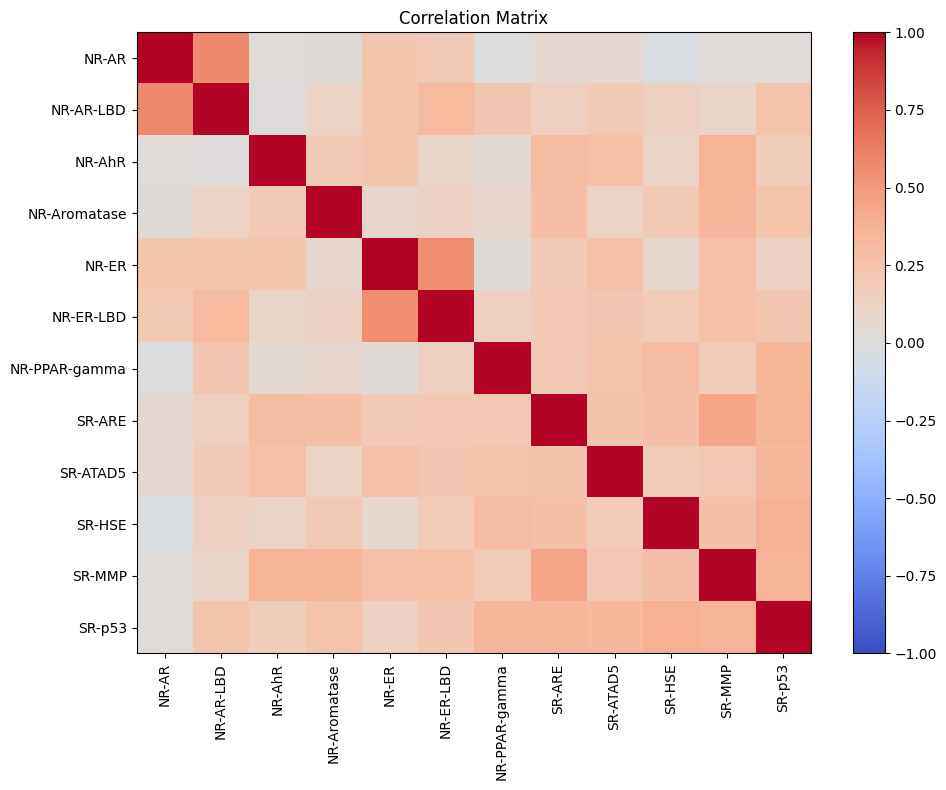

In [118]:
# Plot the distribution of each target column
plt.figure(figsize=(12, 10))
target_columns = tox21.columns[:-2]  # Exclude 'mol_id' and 'smiles' columns
for i, col in enumerate(target_columns):
    plt.subplot(4, 4, i+1)
    tox21[col].value_counts().plot(kind='bar')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
correlation_matrix = tox21.iloc[:, :-2].corr()
plt.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
plt.colorbar()
plt.xticks(range(len(target_columns)), target_columns, rotation=90)
plt.yticks(range(len(target_columns)), target_columns)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

All the features in Tox21 are metrics of toxicity of drugs. They follow the same distribution of CT_TOX seen in Clintox dataset.
Also in this case thus we have way more non-toxic drugs than toxic drugs in the dataset.

From the correlation matrix we can see that there is a small positive correlation between most of the toxicity metrics, but just 2 couples of 2 features have a quite high correlation coefficient between them. These are NR-AR with NR-AR-LBD, and NR-ER with NR-ER-LBD.
After having searched a bit of information on these features, we found that they are all nuclear receptor signaling bioassays results, and the couples of features have very similar meaning, so the correlation is of course there.

## Data Pre-Processing

### Process data

In [107]:
# Remove non valid rows (SMILES that cannot be converted to Canonical SMILES)
def remove_non_valid_rows(df: pd.DataFrame) -> pd.DataFrame:
    mol_list = []
    valid_rows = []
    for i, row in df.iterrows():
        mol = Chem.MolFromSmiles(row['smiles'])
        if mol is not None:
            mol_list.append(mol)
            valid_rows.append(row)

    df = pd.DataFrame(valid_rows)
    return df

#### Clintox dataset

In [108]:
# Clean the database, check for redundancy and remove duplicates

# Remove duplicated rows
print('Clintox dataset dimensions with duplicates:', clintox.shape)
clintox.drop_duplicates(inplace=True) # Drop duplicated rows
print('Clintox dataset dimensions without duplicates:', clintox.shape)

# Remove non valid rows (SMILES that cannot be converted to Canonical SMILES, null SMILES, duplicated SMILES)
clintox = remove_non_valid_rows(clintox) # remove rows with non valid SMILES
clintox.drop_duplicates(subset = ['smiles'], inplace=True) # Remove duplicated canonical SMILES
clintox.dropna(subset=['smiles'], inplace=True) # Remove null SMILES
print('Clintox dataset dimensions without non valid rows:', clintox.shape)
clintox.head(3)

Clintox dataset dimensions with duplicates: (1491, 3)
Clintox dataset dimensions without duplicates: (1484, 3)


[17:37:05] Explicit valence for atom # 0 N, 5, is greater than permitted
[17:37:05] Can't kekulize mol.  Unkekulized atoms: 9


Clintox dataset dimensions without non valid rows: (1478, 3)


[17:37:05] Explicit valence for atom # 10 N, 4, is greater than permitted
[17:37:05] Explicit valence for atom # 10 N, 4, is greater than permitted
[17:37:05] Can't kekulize mol.  Unkekulized atoms: 4
[17:37:05] Can't kekulize mol.  Unkekulized atoms: 4


,smiles,FDA_APPROVED,CT_TOX
0,*C(=O)[C@H](CCCCNC(=O)OCCOC)NC(=O)OCCOC,1,0
1,[C@@H]1([C@@H]([C@@H]([C@H]([C@@H]([C@@H]1Cl)C...,1,0
2,[C@H]([C@@H]([C@@H](C(=O)[O-])O)O)([C@H](C(=O)...,1,0


In [109]:
# Check for null values
clintox.isna().sum()

smiles          0
FDA_APPROVED    0
CT_TOX          0
dtype: int64

#### Tox21 dataset

In [110]:
# Clean the database, check for redundancy and remove duplicates

# Remove duplicated rows
print('Tox21 dataset dimensions with duplicates:', tox21.shape)
tox21.drop_duplicates(inplace=True) # Drop duplicated rows
print('Tox21 dataset dimensions without duplicates:', tox21.shape)

# Remove non valid rows (SMILES that cannot be converted to Canonical SMILES, null SMILES, duplicated SMILES)
tox21 = remove_non_valid_rows(tox21) # remove rows with non valid SMILES
tox21.drop_duplicates(subset = ['smiles'], inplace=True) # Remove duplicated canonical SMILES
tox21.dropna(subset=['smiles'], inplace=True) # Remove null SMILES
print('Tox21 dataset dimensions without non valid rows:', tox21.shape)
tox21.head(3)

Tox21 dataset dimensions with duplicates: (8014, 14)
Tox21 dataset dimensions without duplicates: (8014, 14)


[17:37:05] WARNING: not removing hydrogen atom without neighbors


Tox21 dataset dimensions without non valid rows: (7831, 14)


,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,mol_id,smiles
0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX3021,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3020,CCN1C(=O)NC(c2ccccc2)C1=O
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,TOX3024,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...


In [111]:
# Check for null values
tox21.isna().sum()

NR-AR             569
NR-AR-LBD        1083
NR-AhR           1299
NR-Aromatase     2030
NR-ER            1651
NR-ER-LBD         886
NR-PPAR-gamma    1395
SR-ARE           2026
SR-ATAD5          763
SR-HSE           1381
SR-MMP           2041
SR-p53           1072
mol_id              0
smiles              0
dtype: int64

In [112]:
# Check what to do with all these null values
# We have already removed all the rows with null SMILES

### Train-test split
In the reference papers the split of data is provided, so we'll use their same splits in order to be able to compare our results with the state-of-the-art performances.

#### Clintox Dataset

In [113]:
### Method borrowed from MoleculeNet for random splits of 0.8 / 0.1 / 0.1, train / test / valid 
# Returns index of random train, test, valid datasets in array of [train,test,valid]
def split(dataset,
            seed=None,
            frac_train=.8,
            frac_valid=.1,
            frac_test=.1,
            log_every_n=None):
    """
    Splits internal compounds randomly into train/validation/test.
    """
    np.testing.assert_almost_equal(frac_train + frac_valid + frac_test, 1.)
    if not seed is None:
        np.random.seed(seed)
    num_datapoints = len(dataset)
    train_cutoff = int(frac_train * num_datapoints)
    valid_cutoff = int((frac_train + frac_valid) * num_datapoints)
    shuffled = np.random.permutation(range(num_datapoints))
    return (shuffled[:train_cutoff], shuffled[train_cutoff:valid_cutoff],
            shuffled[valid_cutoff:])

In [114]:
# Split the Clintox dataset into train-test-validation sets with ratios 0.8/0.1/0.1
train_indices, test_indices, valid_indices = split(clintox, frac_train=0.8, frac_valid=0.1, frac_test=0.1)  # Use random seed from MoleculeNet

clintox_train = clintox.iloc[train_indices]
clintox_test = clintox.iloc[test_indices]
clintox_val = clintox.iloc[valid_indices]

clintox_data = [clintox_train, clintox_test, clintox_val]


In [115]:
# Check the number of samples in each set
print("Total number of samples, train: " + str(clintox_data[0].shape[0]))
print("Total number of samples, test: " + str(clintox_data[1].shape[0]))
print("Total number of samples, valid: " + str(clintox_data[2].shape[0]))
print("Total number of samples, train+test+valid: " + str(clintox_data[0].shape[0] + 
                                                           clintox_data[1].shape[0] + 
                                                           clintox_data[2].shape[0]))

Total number of samples, train: 1182
Total number of samples, test: 148
Total number of samples, valid: 148
Total number of samples, train+test+valid: 1478


#### Tox21 Dataset

In [116]:
# Split the Tox21 dataset into train-test-validation sets with ratios 0.8/0.1/0.1
train_indices, test_indices, valid_indices = split(tox21, frac_train=0.8, frac_valid=0.1, frac_test=0.1)  # Use random seed from MoleculeNet

tox21_train = tox21.iloc[train_indices]
tox21_test = tox21.iloc[test_indices]
tox21_val = tox21.iloc[valid_indices]

tox21_data = [tox21_train, tox21_test, tox21_val]

In [117]:
# Check the number of samples in each set
print("Total number of samples, train: " + str(tox21_data[0].shape[0]))
print("Total number of samples, test: " + str(tox21_data[1].shape[0]))
print("Total number of samples, valid: " + str(tox21_data[2].shape[0]))
print("Total number of samples, train+test+valid: " + str(tox21_data[0].shape[0] + 
                                                           tox21_data[1].shape[0] + 
                                                           tox21_data[2].shape[0]))

Total number of samples, train: 6264
Total number of samples, test: 783
Total number of samples, valid: 784
Total number of samples, train+test+valid: 7831


## Modelling

### Using Clintox data

### Using Tox21 data